## Imports necessários para o bom funcionamento do algoritmo.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## Manipulação dos dados, como entrada deles em .csv, visualização das primeiras linhas, converter colunas não numéricas para numéricas e etc.

   _Numero Carteira Beneficiario          _Data Atendimento  40301150  \
0               1499901140624742  2024-01-18 21:00:00-03:00       0.0   
1               1499901124913796  2024-01-25 21:00:00-03:00       0.0   
2               1499901124938430  2023-12-31 21:00:00-03:00       0.0   
3               1499901124938430  2024-01-04 21:00:00-03:00       0.0   
4               1499901124804889  2023-10-10 21:00:00-03:00       0.0   

   40301630  40316130  10101012  40304922  40302458  40301729  40304370  ...  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0  ...   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0  ...   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0  ...   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0  ...   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0  ...   

   03099911_last_7_days  00794910_last_7_days  74605720_last_7_days  \
0        

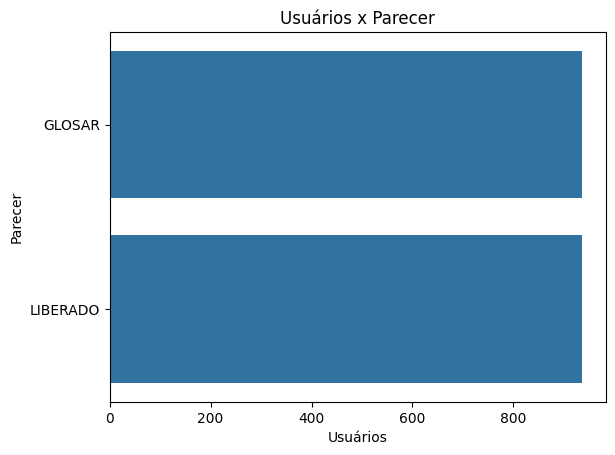

Class mapping: {0: 'GLOSAR', 1: 'LIBERADO'}


In [ ]:
# Aqui ficam os dados
data = pd.read_csv('/content/pivoted_services_teste_total_novo_parecer_balanced.csv')

# Primeiras linhas do dataset
print(data.head())

# Visualizar a distribuição das classes
sns.countplot(data.iloc[:, -1])
plt.title('Usuários x Parecer')
plt.xlabel('Usuários')
plt.ylabel('Parecer')
plt.show()

# Converter colunas não numéricas para numéricas
# Aqui assumo que '_Data Atendimento' e possivelmente outras colunas são do tipo datetime
# Convertemos 'datetime' para um formato numérico (timestamp)
if '_Data Atendimento' in data.columns:
    data['_Data Atendimento'] = pd.to_datetime(data['_Data Atendimento'])
    data['_Data Atendimento'] = data['_Data Atendimento'].astype(np.int64) // 10**9

# Se houver mais colunas categóricas, elas precisam ser convertidas para numéricas também
# Usar LabelEncoder ou OneHotEncoder dependendo da necessidade
# Aqui faremos um LabelEncoder
for col in data.select_dtypes(include=['object']).columns:
    if col != '_Parecer':  # Ignorar a coluna de target
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

class_labels = list(label_encoder.classes_)
encoded_labels = list(range(len(class_labels)))

class_mapping = dict(zip(encoded_labels, class_labels))
print("Class mapping:", class_mapping)

## Divisão dos dados para o treinamento e deixando-o compatível com o modelo de CNN.

In [ ]:
# Aqui divide os dados
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aqui é pra ficar compatível
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

## Aplicação do modelo CNN com suas layers, poolings e camadas densas.

In [ ]:
# Aqui começa o modelo CNN
from tensorflow.keras import layers, models

cnn = models.Sequential()

# Aqui adiciona as layers e os poolings
cnn.add(layers.Conv1D(64, 2, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn.add(layers.MaxPooling1D(2))
cnn.add(layers.Conv1D(128, 2, activation='relu', padding='same'))
cnn.add(layers.MaxPooling1D(2))
cnn.add(layers.Conv1D(256, 2, activation='relu', padding='same'))
cnn.add(layers.MaxPooling1D(2))
cnn.add(layers.Conv1D(512, 2, activation='relu', padding='same'))
cnn.add(layers.Conv1D(1024, 2, activation='relu', padding='same'))
cnn.add(layers.GlobalMaxPooling1D())

# Aqui as camadas densas
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256, activation='relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Dense(256, activation='relu'))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12640, 64)         192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 6320, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 6320, 128)         16512     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3160, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3160, 256)         65792     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1580, 256)         0

## Compilamento, treinamento e acurácia do dataframe em CNN.
Foi dividido em 30 épocas.

In [ ]:
# Compilando
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando
history = cnn.fit(X_train, y_train, epochs=30, batch_size= 16, validation_split=0.2)

# Acurácia
loss, accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/30
66/66 [==============================] - 16s 125ms/step - loss: 0.7247 - accuracy: 0.5000 - val_loss: 0.6984 - val_accuracy: 0.4695
Epoch 2/30
66/66 [==============================] - 6s 95ms/step - loss: 0.6828 - accuracy: 0.5382 - val_loss: 0.6915 - val_accuracy: 0.4618
Epoch 3/30
66/66 [==============================] - 6s 95ms/step - loss: 0.6781 - accuracy: 0.5697 - val_loss: 0.6901 - val_accuracy: 0.5229
Epoch 4/30
66/66 [==============================] - 6s 96ms/step - loss: 0.6905 - accuracy: 0.5344 - val_loss: 0.6989 - val_accuracy: 0.4847
Epoch 5/30
66/66 [==============================] - 6s 96ms/step - loss: 0.6776 - accuracy: 0.5802 - val_loss: 0.6497 - val_accuracy: 0.6450
Epoch 6/30
66/66 [==============================] - 6s 95ms/step - loss: 0.5818 - accuracy: 0.7414 - val_loss: 0.4943 - val_accuracy: 0.7748
Epoch 7/30
66/66 [==============================] - 6s 96ms/step - loss: 0.5306 - accuracy: 0.7519 - val_loss: 0.4740 - val_accuracy: 0.7863
Epoch 8/30


## Visualizar a precisão da CNN

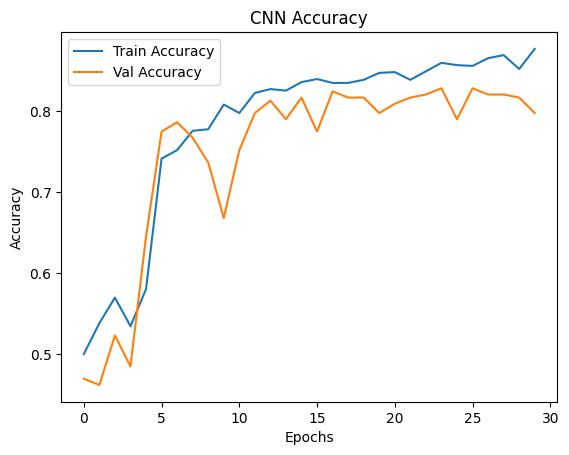

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualizar a perda da CNN

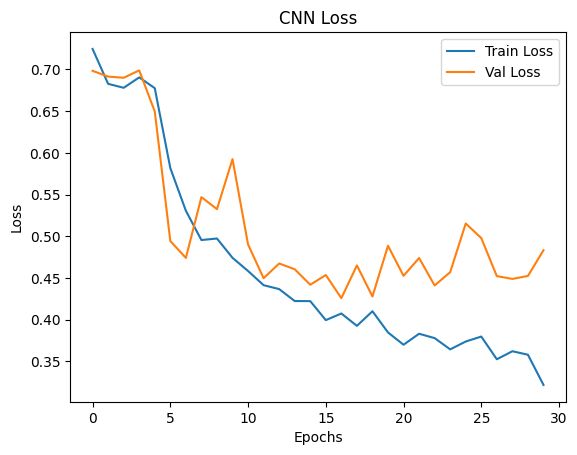

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predições da CNN com visualização

In [ ]:
# Predições da CNN
cnn_predictions = cnn.predict(X_test)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Mostrar algumas predições
print("CNN Predictions:", cnn_pred_classes[:10])


18/18 [==============================] - 1s 66ms/step
CNN Predictions: [0 1 1 0 0 0 0 1 0 0]


## Matriz de confusão da CNN

CNN Test Accuracy: 0.7758007117437722


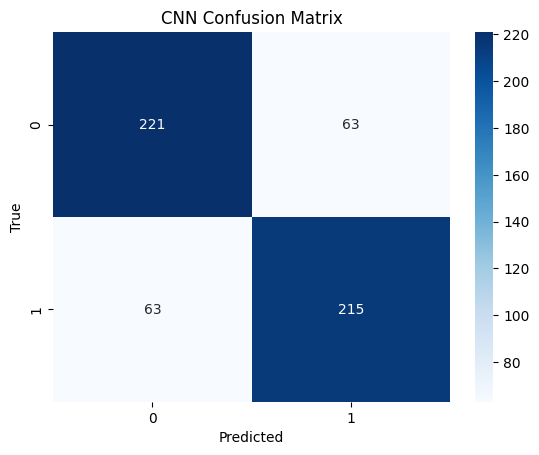

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Avaliar a CNN
cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
print(f"CNN Test Accuracy: {cnn_accuracy}")

# Matriz de confusão da CNN
cnn_cm = confusion_matrix(y_test, cnn_pred_classes)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Comparativo com um modelo de Random Forest
Ajustes para o modelo de Random Forest, predições e acurácia.
Foi dividida em 100 árvores.

In [ ]:
# Comparativo com um modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier

# Ajustando o modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predições da Random Forest
rf_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

# Acurácia da Random Forest
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Test Accuracy: {rf_accuracy}")

Random Forest Test Accuracy: 0.8701067615658363


## Matriz de confusão da Random Forest

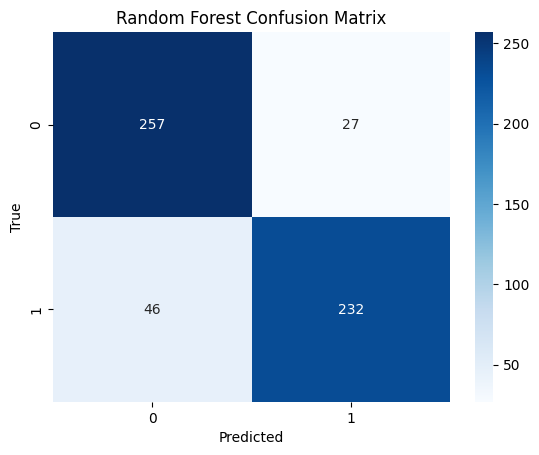

In [ ]:
# Matriz de confusão da Random Forest
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Resumo das acurácias

In [ ]:
# Resumo das acurácias
print(f"CNN Test Accuracy: {accuracy}")
print(f"Random Forest Test Accuracy: {rf_accuracy}")

CNN Test Accuracy: 0.7758007049560547
Random Forest Test Accuracy: 0.8701067615658363
